## Importing the necesarry libraries

In [3]:
# print(os.listdir("/kaggle/working/"))

In [1]:
import numpy as np # linear algebra
import pandas as pd 
import os
import pickle #for saving the image features


from PIL import Image #for image visualisation
from tqdm.notebook import tqdm # how much data is process till now
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50 #for feature extraction
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img , img_to_array #convert img to np array that will be fed into the model
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

2024-08-23 16:26:26.886117: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 16:26:26.886210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 16:26:27.005361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Checking for GPU

In [2]:
print(f"Tensorflow Version: {tf.__version__}")
print(f"Number of GPUs Available: {len(tf.config.list_physical_devices('GPU'))} ")
if tf.config.list_physical_devices('GPU'):
    print("GPU Device name", tf.test.gpu_device_name())

print(f"Number of TPUs Available: {len(tf.config.list_physical_devices('TPU'))}")
# if tf.config.list_physical_devices('TPU'):
#     print("TPU Device name", tf.test.tpu_device_name())

Tensorflow Version: 2.15.0
Number of GPUs Available: 1 
GPU Device name /device:GPU:0
Number of TPUs Available: 0


### Package for visualing ResNet50

In [3]:
pip install visualkeras

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 27.3 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


## Defining the directories

In [4]:
CAPTIONS_PATH = '/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json'
IMAGES_PATH = '/kaggle/input/coco-2017-dataset/coco2017/train2017'

### Seeing the number of images of the whole coco dataset

In [5]:
img_names = os.listdir(IMAGES_PATH)
print("number of images", len(img_names))

number of images 118287


## Making the dataframe 

In [6]:
import json

# Open the captions_train2017.json file
with open(CAPTIONS_PATH, 'r') as f:
    data = json.load(f)
    data = data['annotations']
    
# Checking the number of captions
num_captions = len(data)
print(f"Number of captions in captions_train2017: {num_captions}")

print(data[0:3])

Number of captions in captions_train2017: 591753
[{'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}, {'image_id': 322141, 'id': 49, 'caption': 'A room with blue walls and a white sink and door.'}, {'image_id': 16977, 'id': 89, 'caption': 'A car that seems to be parked illegally behind a legally parked car'}]


### Flattening json data into a dataframe and also adding the image path

In [7]:
df = pd.json_normalize(data)

# add zeros to the image id
df['image_id'] = df['image_id'].apply(lambda x: "{:012}".format(x))

# add the image path to df
df['image'] = df['image_id'].apply(
    lambda x: f'/kaggle/input/coco-2017-dataset/coco2017/train2017/{x}.jpg'
)

df.drop(columns = ['id'], inplace = True)

df
# in df there is each image id with 5 captions, so image_id is repeated

image_id                                            caption  \
0       000000203564  A bicycle replica with a clock as the front wh...   
1       000000322141  A room with blue walls and a white sink and door.   
2       000000016977  A car that seems to be parked illegally behind...   
3       000000106140  A large passenger airplane flying through the ...   
4       000000106140  There is a GOL plane taking off in a partly cl...   
...              ...                                                ...   
591748  000000133071  a slice of bread is covered with a sour cream ...   
591749  000000410182  A long plate hold some fries with some sliders...   
591750  000000180285       Two women sit and pose with stuffed animals.   
591751  000000133071  White Plate with a lot of guacamole and an ext...   
591752  000000133071      A dinner plate has a lemon wedge garnishment.   

                                                    image  
0       /kaggle/input/coco-2017-dataset/coco2017/train...  
1       /kaggle/input/coco-2017-dataset/coco2017/train...  
2       /kaggle/input/coco-2017-dataset/coco2017/train...  
3       /kaggle/input/coco-2017-dataset/coco2017/train...  
4       /kaggle/input/coco-2017-dataset/coco2017/train...  
...                                                   ...  
591748  /kaggle/input/coco-2017-dataset/coco2017/train...  
591749  /kaggle/input/coco-2017-dataset/coco2017/train...  
591750  /kaggle/input/coco-2017-dataset/coco2017/train...  
591751  /kaggle/input/coco-2017-dataset/coco2017/train...  
591752  /kaggle/input/coco-2017-dataset/coco2017/train...  

[591753 rows x 3 columns]

## Sampling 5000 images inorder to work with a subset of coco dataset)

In [8]:
sampled_image_ids = df['image_id'].drop_duplicates().sample(5000, random_state=42)

sampled_df = df[df['image_id'].isin(sampled_image_ids)]

sampled_df = sampled_df.reset_index(drop=True)

sampled_df


image_id                                            caption  \
0      000000133680        A man is sitting on a bench next to a bike.   
1      000000133680     A man is sitting on a bench next to a bicycle.   
2      000000334015  a small toilet stall with a toilet brush and 3...   
3      000000133680           A man sits on a street bench by a bike.    
4      000000334015  A clean, European toilet with toilet paper and...   
...             ...                                                ...   
25003  000000102090  Several friends are standing around drinking s...   
25004  000000102090  They had some wine in glasses as they waited n...   
25005  000000276796  A wooden clock with a dark stain placed on a b...   
25006  000000276796        A small clock sits on a small black table.    
25007  000000102090  Young men stand next to a table holding wine g...   

                                                   image  
0      /kaggle/input/coco-2017-dataset/coco2017/train...  
1      /kaggle/input/coco-2017-dataset/coco2017/train...  
2      /kaggle/input/coco-2017-dataset/coco2017/train...  
3      /kaggle/input/coco-2017-dataset/coco2017/train...  
4      /kaggle/input/coco-2017-dataset/coco2017/train...  
...                                                  ...  
25003  /kaggle/input/coco-2017-dataset/coco2017/train...  
25004  /kaggle/input/coco-2017-dataset/coco2017/train...  
25005  /kaggle/input/coco-2017-dataset/coco2017/train...  
25006  /kaggle/input/coco-2017-dataset/coco2017/train...  
25007  /kaggle/input/coco-2017-dataset/coco2017/train...  

[25008 rows x 3 columns]

## Visualising the dataset

A doughnut sits on a napkin, with red frosting and one missing bite.



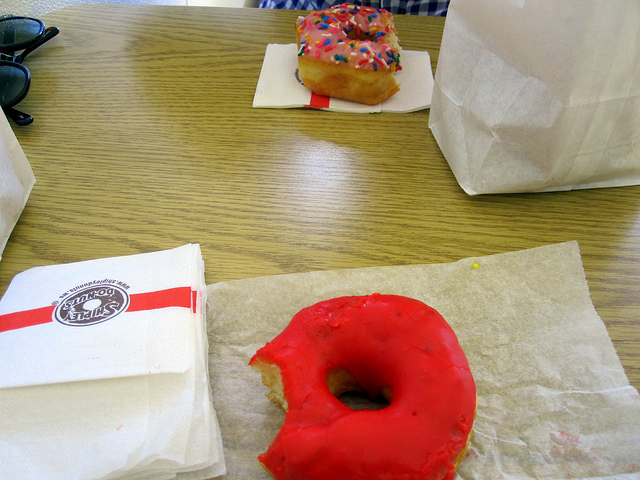

In [9]:
# random sample
random_row = sampled_df.sample(1).iloc[0]
print(random_row.caption)
print()
im = Image.open(random_row.image)
im

## defining the feature extraction model 

In [10]:
img_model = ResNet50()
img_model = Model(inputs = img_model.inputs , outputs = img_model.layers[-2].output)
img_model.summary()

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

/opt/conda/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


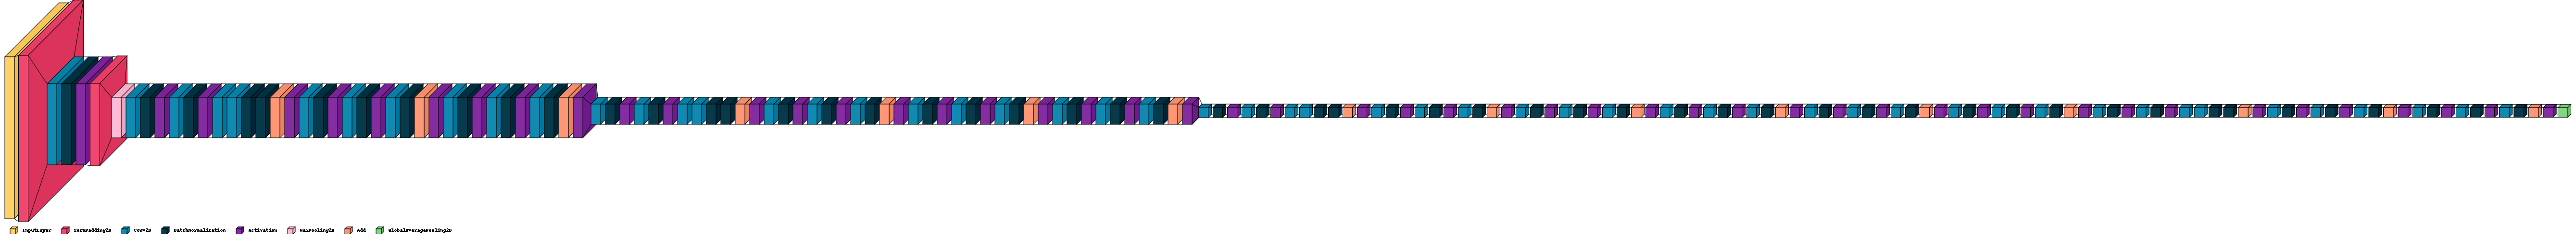

In [11]:
# visualize ResNet50:
import visualkeras
visualkeras.layered_view(img_model, draw_volume=True, scale_xy=1.5,scale_z=0.01, legend=True)

## Feature extraction

In [12]:
img_directory = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
IMG_SIZE = 224

In [13]:
#dictionary to store the image features
features = {}

# Iterating over the unique image paths in the subset dataset
for image in tqdm(sampled_df['image'].unique().tolist()):
    # Construct the image path by joining the base directory with the image name
    img_path = os.path.join(img_directory, os.path.basename(image))
    
    # Load and preprocess the image 
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    
    #  Normalize the image
#     img = img / 255.0
    img = preprocess_input(img)
    
    # Expanding the dimensions of the image array to match the model's input shape
#     img = np.expand_dims(img, axis=0)

    # Extract the features by passing the preprocessed image through the feature extraction model
    feature = img_model.predict(img, verbose=0)
    
    # Store the extracted features in a dictionary with the image path as the key
    image_id = image.split('/')[-1]
    image_id = image_id.split('.')[0]
    features[image_id] = feature

  0%|          | 0/5000 [00:00<?, ?it/s]

I0000 00:00:1724430471.047920      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [14]:
# for image_id, feature_vector in features.items():
# #     print(f"Image ID: {image_id}, Feature Vector Shape: {feature_vector.shape}")
#     assert feature_vector[0].shape == (2048,), f"Unexpected shape for image ID {image_id}"

In [15]:
# import numpy as np

# # Check for NaNs or infinite values
# for image_id, feature_vector in features.items():
#     if np.isnan(feature_vector[0]).any() or np.isinf(feature_vector[0]).any():
#         print(f"NaN or Inf values found in feature vector for image ID {image_id}")

# # View a sample feature vector
# sample_image_id = next(iter(features))
# print(f"Sample Feature Vector for Image ID {sample_image_id}: {features[sample_image_id]}")


Sample Feature Vector for Image ID 000000133680: [[0.29021624 0.27133903 0.06558812 ... 0.37975708 0.07118617 0.11902378]]


In [ ]:
features['000000133680'][0].shape

In [17]:
for elem in features['000000133680'][0]:
    print(elem)


0.29021624
0.27133903
0.065588124
0.79067415
0.24960156
1.5717993
0.18138456
0.43707138
0.90736455
1.084345
0.037671056
0.0010672881
0.0
0.21257319
0.22707354
0.06026769
0.47056985
0.57803875
0.06734827
1.0477178
0.6345722
0.28423172
0.1191377
0.53344935
0.11525806
0.22661625
0.43952447
0.42915055
0.63184494
0.044167064
0.7828829
1.7144805
0.2585401
1.5116539
0.22941802
0.75530815
0.0
0.66660416
0.0
1.2798864
0.8054749
0.29400602
0.102206185
2.3900452
0.050557747
0.0
0.05053516
0.4764547
0.46615273
0.12444036
0.019888278
0.18095149
0.0029862607
0.36361998
0.23832478
1.0397494
0.28539854
0.10438734
0.94665074
0.0468268
0.7489775
1.2172042
0.05247075
0.0032703534
0.21002197
0.12194659
1.8442714
0.5322361
0.6307362
0.025135448
0.79511327
0.081557974
0.0
0.73070604
0.27066147
0.113208376
1.203997
0.6351627
0.6120036
0.10025406
1.3729856
0.038350534
0.019470017
0.15785566
0.637429
0.62153685
1.9552444
0.5835585
1.0646776
0.012694757
1.009815
0.9132291
0.051920246
0.51021665
0.046329312
0.92

In [18]:
INPUT_DIR = '/kaggle/input/'

In [19]:
WORKING_DIR = '/kaggle/working'

In [20]:

# # storing features in pickle
# with open(os.path.join(INPUT_DIR, 'features.pkl'), 'wb') as f:
#     pickle.dump(features, f)

In [21]:
# # load features from pickle
# with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
#     features = pickle.load(f)

In [22]:
# print(os.listdir('/kaggle/working/'))

##  clean the captions

In [23]:
import re
def preprocess(text):
    text = text.lower()
#     remove non alphanumeric or whitespace characters
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    text = 'startseq ' + ' '.join([word for word in text.split() if len(word) > 1]) + ' endseq'
    return text

In [24]:
sampled_df['caption'] = sampled_df['caption'].apply(preprocess)
sampled_df

image_id                                            caption  \
0      000000133680  startseq man is sitting on bench next to bike ...   
1      000000133680  startseq man is sitting on bench next to bicyc...   
2      000000334015  startseq small toilet stall with toilet brush ...   
3      000000133680   startseq man sits on street bench by bike endseq   
4      000000334015  startseq clean european toilet with toilet pap...   
...             ...                                                ...   
25003  000000102090  startseq several friends are standing around d...   
25004  000000102090  startseq they had some wine in glasses as they...   
25005  000000276796  startseq wooden clock with dark stain placed o...   
25006  000000276796  startseq small clock sits on small black table...   
25007  000000102090  startseq young men stand next to table holding...   

                                                   image  
0      /kaggle/input/coco-2017-dataset/coco2017/train...  
1      /kaggle/input/coco-2017-dataset/coco2017/train...  
2      /kaggle/input/coco-2017-dataset/coco2017/train...  
3      /kaggle/input/coco-2017-dataset/coco2017/train...  
4      /kaggle/input/coco-2017-dataset/coco2017/train...  
...                                                  ...  
25003  /kaggle/input/coco-2017-dataset/coco2017/train...  
25004  /kaggle/input/coco-2017-dataset/coco2017/train...  
25005  /kaggle/input/coco-2017-dataset/coco2017/train...  
25006  /kaggle/input/coco-2017-dataset/coco2017/train...  
25007  /kaggle/input/coco-2017-dataset/coco2017/train...  

[25008 rows x 3 columns]

### put all the captions in a list

In [25]:
captions = sampled_df['caption'].tolist()
print(len(captions))
print(len(captions))
captions[:10]



25008
25008


['startseq man is sitting on bench next to bike endseq',
 'startseq man is sitting on bench next to bicycle endseq',
 'startseq small toilet stall with toilet brush and rolls of toilet paper endseq',
 'startseq man sits on street bench by bike endseq',
 'startseq clean european toilet with toilet paper and cleaning brush endseq',
 'startseq public toilet stall with toilet paper and cleaning brush endseq',
 'startseq black man sitting on bench behind personal bicycle endseq',
 'startseq group of men standing in front of bar having conversation endseq',
 'startseq an empty clean toilet stall with stack of toilet paper endseq',
 'startseq man is sitting in busy area with his bike endseq']

## Create the vocab(where each word appearing in the captions list has a number) using the list of captions

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions) #create the "word => number" vocab

vocab_size = len(tokenizer.word_index) + 1 
max_length = max(len(caption.split()) for caption in captions) #max length of the caption will be used as a parameter while padding

# exploring how the text_to_sequences() works
tokenizer.texts_to_sequences(captions[:4])


[[1, 10, 9, 12, 3, 98, 19, 11, 247, 2],
 [1, 10, 9, 12, 3, 98, 19, 11, 387, 2],
 [1, 33, 69, 802, 7, 69, 515, 8, 1160, 4, 69, 283, 2],
 [1, 10, 95, 3, 22, 98, 47, 247, 2]]

In [27]:
print(vocab_size)
print("max_length of caption:", max_length)

7292
max_length of caption: 41


In [28]:
print(vocab_size)

7292


In [29]:
print(tokenizer.word_index.get("endseq", None))
print(tokenizer.word_index.get("startseq", None))


2
1


### map image ids with captions


In [30]:
grouped = sampled_df.groupby('image_id')
i = 0
captions_mapping = {}
for image_id, group in grouped:
    captions = []
    for caption in group['caption']:
        captions.append(caption)
    captions_mapping[image_id] = captions

In [31]:
print(captions_mapping['000000406282'])
len(captions_mapping)

['startseq group of people sitting in the woods at table that has food on it endseq', 'startseq group of people sitting around eating at table endseq', 'startseq couple of people are sitting at wood bench endseq', 'startseq group of people eating at picnic table in wooded area endseq', 'startseq couple of people that are on picnic table endseq']


5000

## Getting the pretrained embeddings from GloVe

In [32]:
# # glove embeddings with 50 features
# GLOVE_PATH = "/kaggle/input/glove-embeddings/glove.6B.50d.txt"

In [33]:
# f = open(GLOVE_PATH, encoding = 'utf8')

### Get all the word embeddings present in glove and map them with their word

In [34]:
# word_embedding = {}
# for line in f:
#     values = line.split()
#     word = values[0]
#     embedding = np.array(values[1:], dtype = 'float')
#     word_embedding[word] = embedding

In [35]:
# # Seeing the pretrained word embeddings on a random word
# sample_embedding = word_embedding['dance']
# print(sample_embedding)
# print(sample_embedding.shape)

### Now next task is to generate an embedding matrix which contains the embeddings of each word(if it also exists in our glove dataset) of our vocab.
- The dimensions of the embedding matrix = (vocab_len, 50) since we are using the 50 dimensional GloVe dataset
- Each row in the embedding matrix represents a word

In [36]:
# def get_embedding_matrix(vocab_size, emb_dim):
#     emb_matrix = np.zeros((vocab_size, emb_dim))
#     for word, i in tokenizer.word_index.items():
#         emb_vector = word_embedding.get(word)
#         if emb_vector is not None:
#             emb_matrix[i] = emb_vector
#     return emb_matrix

In [37]:
# EMB_DIM = 50
# emb_matrix = get_embedding_matrix(vocab_size, EMB_DIM)

## Model Architecture

In [38]:
from tensorflow.keras.layers import Masking
# <----ENCODER---->
# Input the image features
input_img_features = Input(shape= (2048,), name = 'image') #dimensions same as the output of 3rd last layer of ResNet50[]
inp_img_1 = Dropout(0.5)(input_img_features)
inp_img_2 = Dense(256, activation = 'relu')(inp_img_1)

# input captions
input_captions = Input(shape = (max_length,), name = 'text') #input of captions is in the form of tokens [20,1,203..], so embedded them
# each tokenised word is of vocab_size due to padding
# embedding = Embedding(input_dim = vocab_size, output_dim = EMB_DIM, weights = [emb_matrix], mask_zero = True, trainable = True)
# inp_cap1 = embedding(input_captions)
inp_cap1 = Embedding(input_dim = vocab_size, output_dim = 256 ,mask_zero=True)(input_captions)
se2 = Masking(mask_value=0.0)(inp_cap1) # to ensure that input seq are correctly ,masked to the right
inp_cap2 = Dropout(0.5)(se2)
inp_cap3 = LSTM(256, return_sequences=False)(inp_cap2)

# inp_cap2 = Dropout(0.3)(inp_cap1)
# inp_cap3 = LSTM(256)(inp_cap2)

# <-----DECODER----->
decoder1 = add([inp_img_2, inp_cap3], name="decoder_add")
decoder2 = Dense(256, activation='relu', name="decoder_dense1")(decoder1)
outputs = Dense(vocab_size, activation='softmax', name="decoder_dense2")(decoder2)

model = Model(inputs=[input_img_features, input_captions], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [39]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None, 41)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 41, 256)   │  1,866,752 │ text[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image (InputLayer)  │ (None, 2048)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 41, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 41, 256)   │          0 │ embedding[0][0]   │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ image[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 41, 256)   │          0 │ masking[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 41)        │          0 │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_add (Add)   │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense1      │ (None, 256)       │     65,792 │ decoder_add[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense2      │ (None, 7292)      │  1,874,044 │ decoder_dense1[0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,856,444 (18.53 MB)

 Trainable params: 4,856,444 (18.53 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
max_length

41

In [41]:
pip install pydot

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


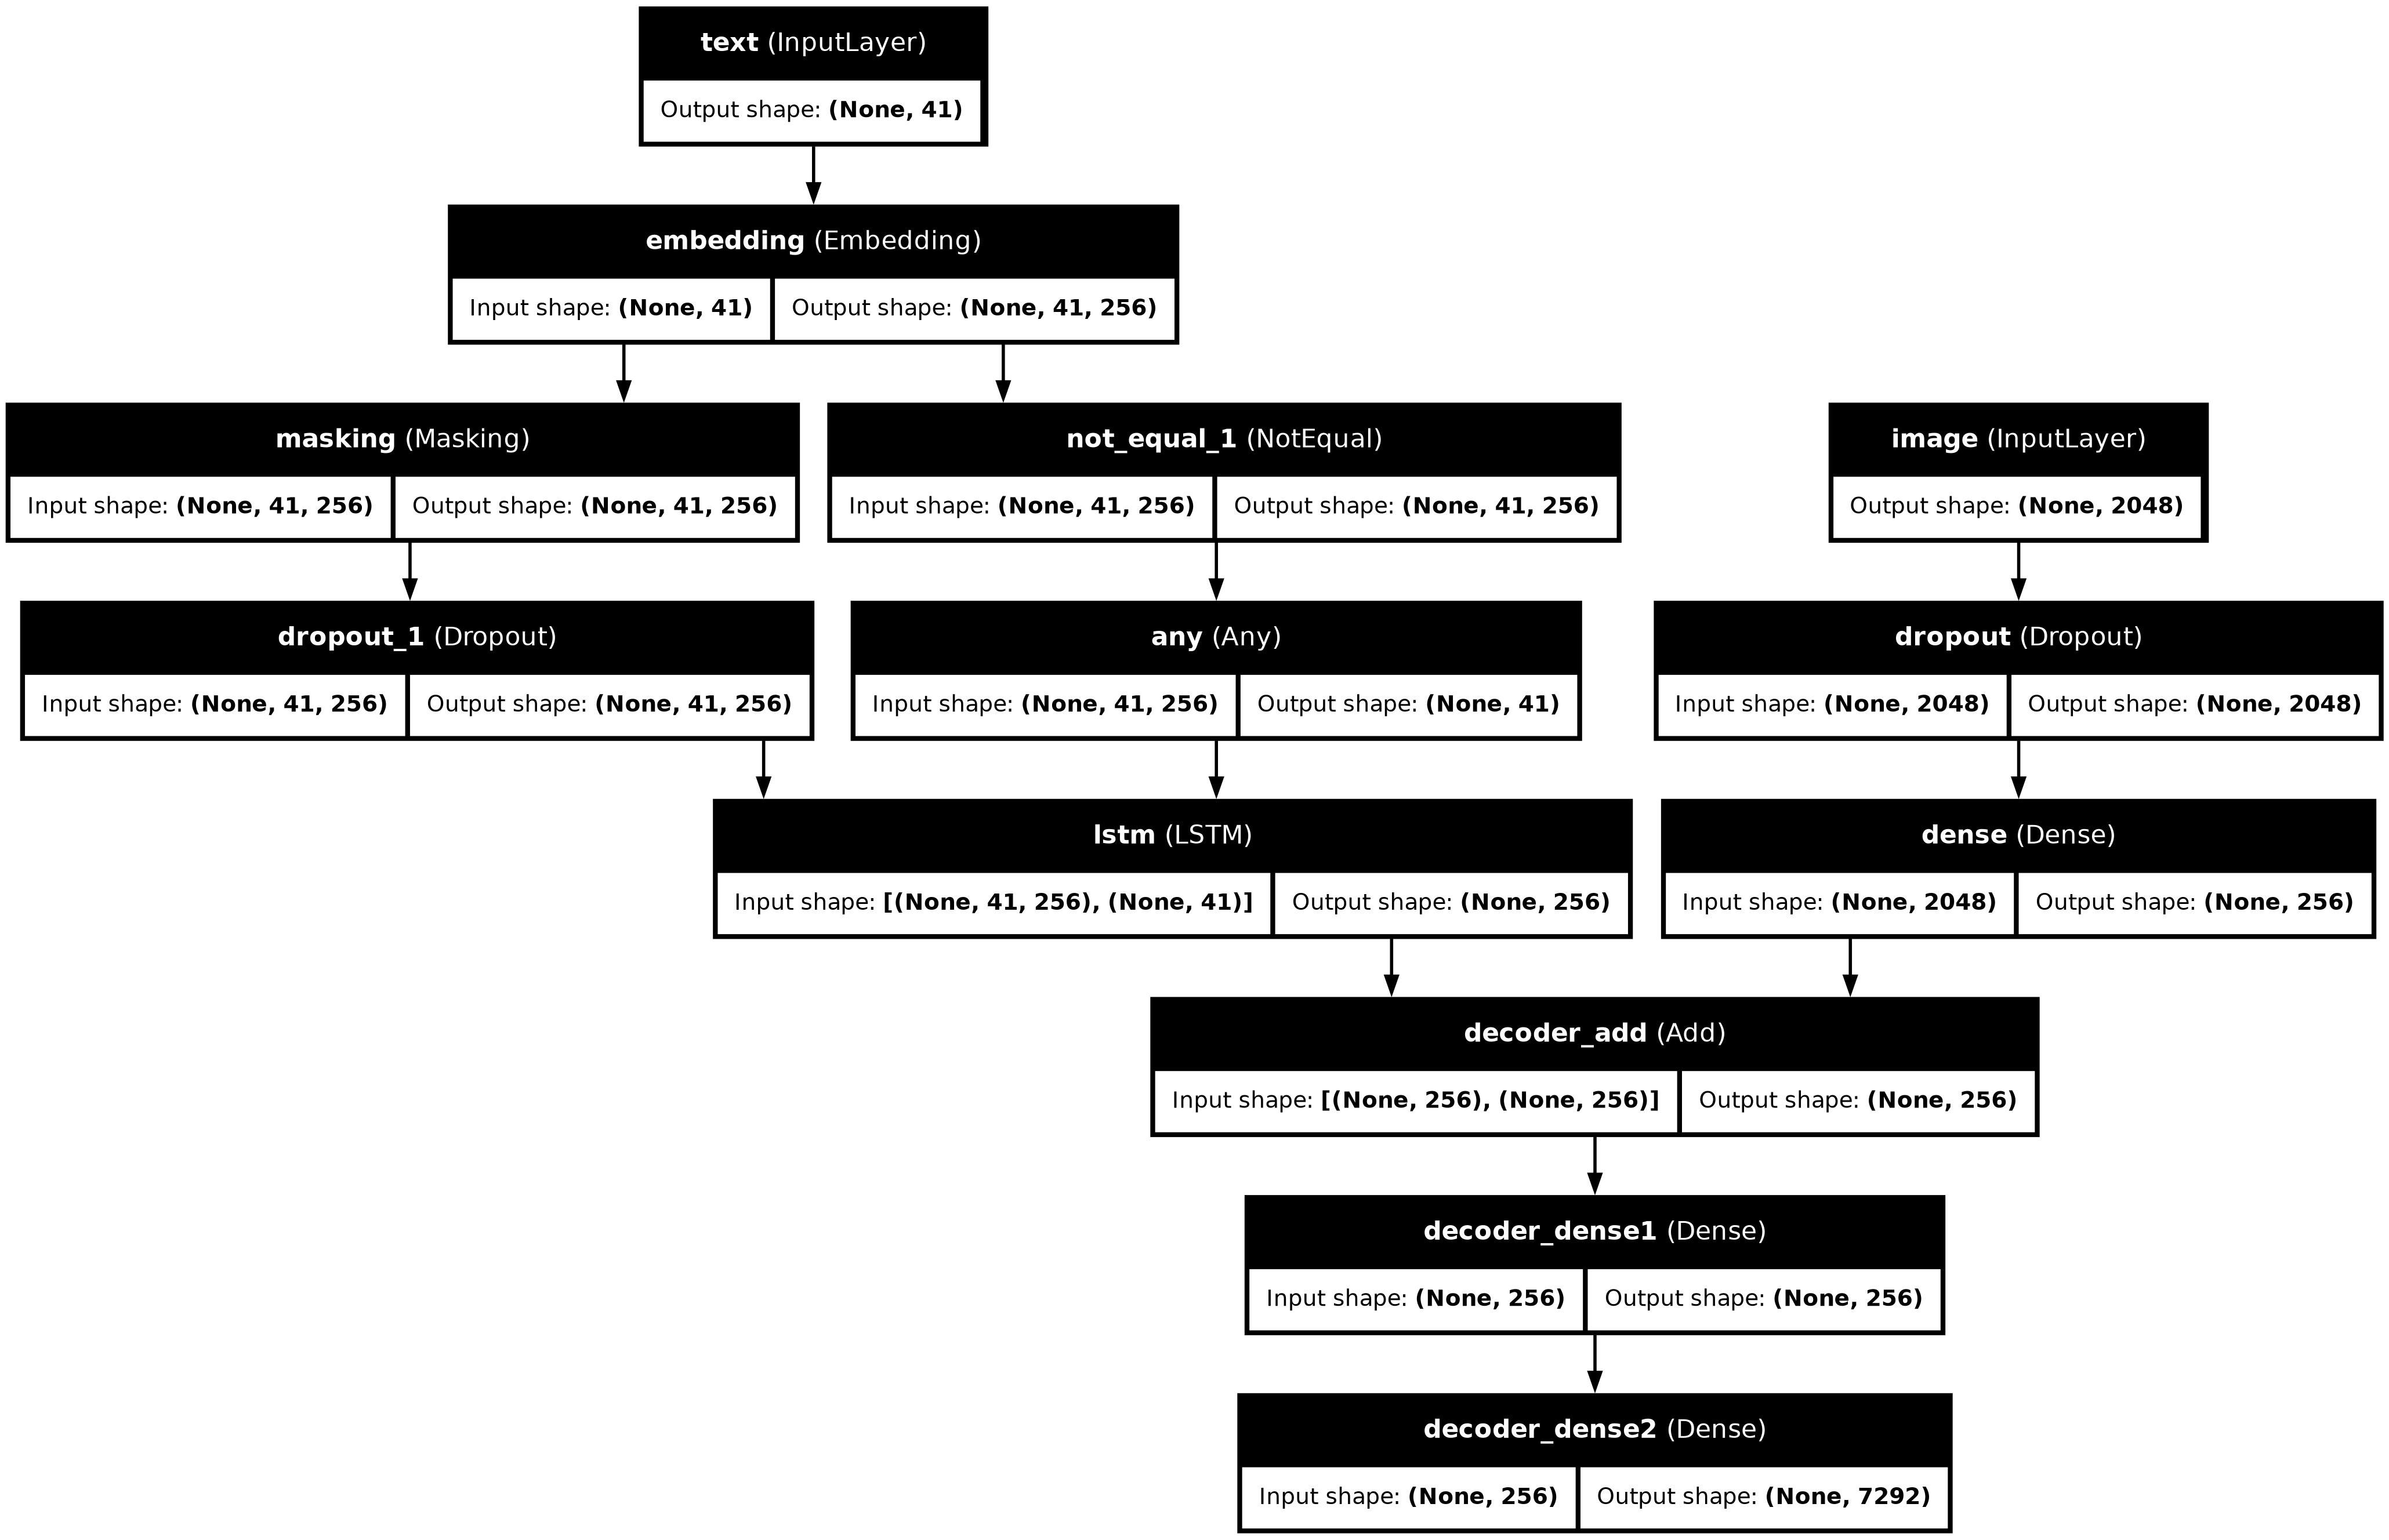

In [42]:
# visualing the model
plot_model(model, show_shapes=True, show_layer_names = True)

Note: the NotEqual operation isn't a layer but represents the masking logic. The connection between this "layer" and the LSTM indicates that the mask is directly passed to the LSTM, allowing it to ignore the padding tokens.

## Test train split

In [43]:
img_id = list(captions_mapping.keys())
split = int(len(img_id)*0.90)

train_final = img_id[:split]
test_final = img_id[split:]

print(len(train_final))
print(len(test_final))

print(train_final[:10])

4500
500
['000000000194', '000000000250', '000000000308', '000000000436', '000000000486', '000000000761', '000000000873', '000000000943', '000000001144', '000000001176']


## Creating a generator function which will yield data in batches
- The dataGenerator function will provide batches one at a time using the yield statement. 
- "yield" gives interim results unlike "return" which gives one output
- Thus we need not load the entire dataset into the memory at once.


In [44]:
print(tokenizer.texts_to_sequences(['a man standing'])[0])

[10, 18]


In [45]:
# # <----FLOW ---->
# # first iterate over all the img_ids
# # Then in each img id, iterate over all the captions
# # then in each caption, generate in_seq and out_seq

def dataGenerator(data_keys,captions,features,tokenizer,max_len,vocab_size,batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key in data_keys:
            n+=1
            data = captions[key]
            for caption in data:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split seq into X,y pairs
                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input seq:
                    in_seq = pad_sequences([in_seq], maxlen=max_len, padding = 'post')[0]
                    # encode output seq:
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==batch_size:
                X1, X2, y = np.array(X1),np.array(X2),np.array(y)
                yield {"image": X1, "text": X2}, y # (X1, X2) , y  also works i.e give tf tuples 
                X1,X2,y = list(),list(),list()
                n=0

When does the data generator function stop?
After completing the steps_per_epoch, the generator stops being called . i.e it stops after every epoch.

So we need a loop to iterate over the epochs and call the generator in each epoch

In [59]:
# train the model
epochs = 20
batch_size = 32
steps = len(train_final) // batch_size

for i in range(epochs):
    
    # create data generator
    generator = dataGenerator(train_final, captions_mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 212ms/step - loss: 4.2116
140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 209ms/step - loss: 4.1996
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 211ms/step - loss: 4.1810
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 211ms/step - loss: 4.1648
140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 209ms/step - loss: 3.9394
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 212ms/step - loss: 3.6154
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 211ms/step - loss: 3.3591
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 211ms/step - loss: 3.1738
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 211ms/step - loss: 3.0383
140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 211ms/step - loss: 2.9284
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 212ms/step - loss: 2.8318
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 212ms/step - loss: 2.7537
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 212ms/step - loss: 2.6875
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 212ms/step - loss: 2.6209
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 213ms/step - loss: 2.5679
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 212ms/step - loss: 2.5173
140/140 ━━━━━━━━━━━━━━━━━━━━ 29s 211ms/step - loss: 2.46

In [60]:
# save the model
model.save(WORKING_DIR+'/first_model.h5')

## Generate Captions for the Image

In [61]:
def idx_to_word(index, tokenizer):
    return tokenizer.index_word.get(index, None)

In [62]:
print(tokenizer.index_word.get(4, None))

of


In [63]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    
    # add start tag for generation process
    in_text = 'startseq'
    
    # iterate over the max length of sequence
    for i in range(max_length):
        
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding = 'post') #ensure that the padding is to the right
        
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        
        # get index with high probability
        yhat = np.argmax(yhat)
        
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        
        # stop if word not found
        if word is None:
            break
            
        # append word as input for generating next word
        in_text += " " + word
        
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

## Evaluate using bleu score

In [76]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# validate with test data
actual, predicted = list(), list()

for key in tqdm(test_final):
    
    # get actual caption
    captions = captions_mapping[key]
    
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
smooth_fn = SmoothingFunction().method1
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function = smooth_fn ))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function = smooth_fn))

  0%|          | 0/500 [00:00<?, ?it/s]

BLEU-1: 0.553085
BLEU-2: 0.333717


### Generating / Predicting captions from the image id

In [64]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(IMAGES_PATH, image_name)
    image = Image.open(img_path)
    captions = captions_mapping[image_id]
    print('---------------------Actual Caption---------------------')
    for caption in captions:
        print(caption)
        
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted Caption--------------------')
    print(y_pred)
    plt.imshow(image)

## Testing the model

In [95]:
print(len(test_final))
test_final[15:20]

500


['000000524611',
 '000000524623',
 '000000524646',
 '000000524816',
 '000000525021']

---------------------Actual---------------------
startseq group of three people sitting on couch endseq
startseq group of people are sitting on the couch endseq
startseq three people sitting on couch looking binder of paper endseq
startseq three people sitting on coach in front of laptop endseq
startseq boy and older people are sitting on the couch endseq
--------------------Predicted--------------------
startseq group of people sitting at table with wine endseq


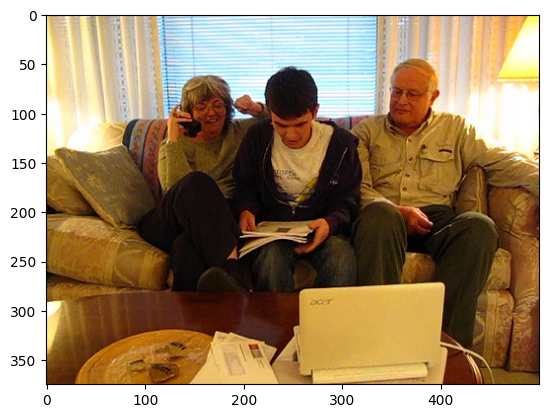

In [89]:
generate_caption('000000523637.jpg')

---------------------Actual---------------------
startseq hot dog sitting on top of bun covered in toppings endseq
startseq cooked food item with cheese and onions served in basket endseq
startseq hotdog with cheese and onions in basket endseq
startseq chili dog sits in basket near french fries endseq
startseq large hot dog that has cheese on top of it endseq
--------------------Predicted--------------------
startseq sandwich with coca onions and coca onions and coca onions and coca onions and coca onions and coca onions and coca fries and coca onions and coca fries and coca fries and coca fries and fries and fries and sandwich sandwich


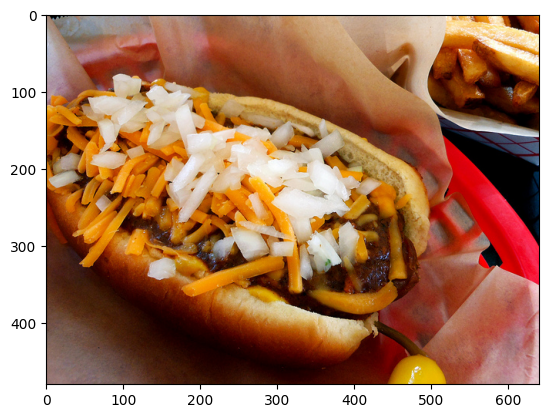

In [90]:
generate_caption('000000523211.jpg')

---------------------Actual---------------------
startseq tennis player retrieving ball from the courts surface endseq
startseq boy reaching for tennis ball on court endseq
startseq man bending down to pick up tennis ball on blue tennis court endseq
startseq man with racquet and ball bending over endseq
startseq the young player is picking tennis ball up off the court endseq
--------------------Predicted--------------------
startseq tennis player playing tennis on tennis court endseq


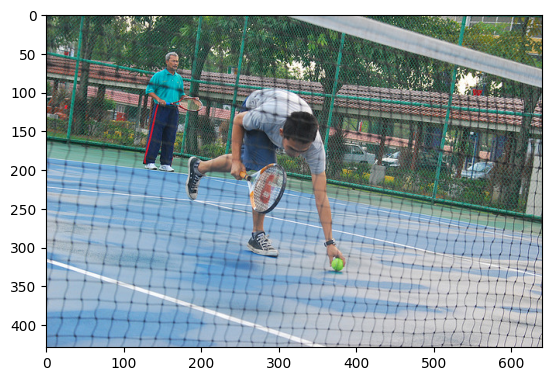

In [80]:
generate_caption('000000522234.jpg')

---------------------Actual---------------------
startseq the overhead view of land mass taken from high above endseq
startseq picture or sand where something was dropped endseq
startseq the paint is peeling off the wall in the room endseq
startseq large puddle of filthy water on top of dirty ground endseq
startseq dirty water or clay running through something brown endseq
--------------------Predicted--------------------
startseq man in the water is flying on the water endseq


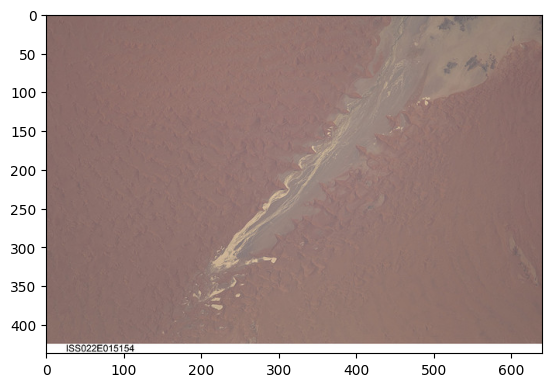

In [67]:
generate_caption('000000522527.jpg')

---------------------Actual---------------------
startseq package tied to an umbrella floating to the ground endseq
startseq an umbreall with present tied to the end of it is in the air endseq
startseq an umbrella hanging in the air with box hanging under it endseq
startseq gift box is suspended from large black umbrella endseq
startseq box tied to an umbrella floating in the air endseq
--------------------Predicted--------------------
startseq an orange and yellow an orange and yellow and yellow yellow and yellow yellow and yellow yellow and yellow yellow and yellow yellow and yellow yellow and yellow and yellow head endseq


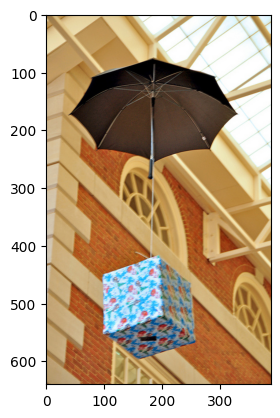

In [68]:
generate_caption('000000525824.jpg')

---------------------Actual---------------------
startseq couple of zebras are out in the wild endseq
startseq two zebras frolicking and having fun in field endseq
startseq two zebras in green field and some trees and clouds endseq
startseq few zebra standing on top of lush green field endseq
startseq couple of zebras playing in field and grazing endseq
--------------------Predicted--------------------
startseq two animals grazing in the grass in the grass endseq


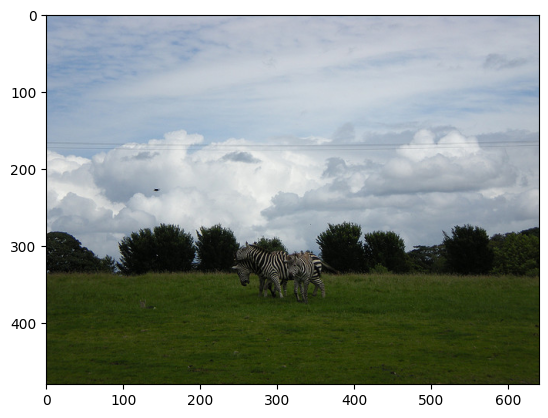

In [73]:
generate_caption('000000522438.jpg')

---------------------Actual---------------------
startseq skate boarder rides his board on the edge of concrete feature endseq
startseq skateboarder performs trick while being photographed endseq
startseq skate boarder shows off his skills talentedly endseq
startseq boy standing on top of concrete block about to jump on skate board endseq
startseq boy doing tricks on his skateboard on ramp endseq
--------------------Predicted--------------------
startseq man on skateboard doing trick on skateboard endseq


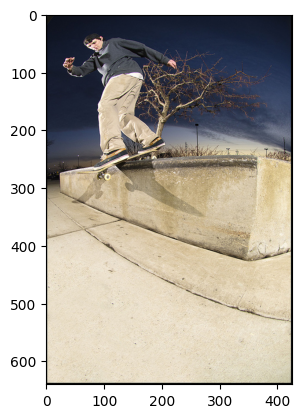

In [71]:
generate_caption('000000522192.jpg')

---------------------Actual---------------------
startseq two motorcycle riders leaving out on ride endseq
startseq two people sitting on black motorcycle across from other cyclists endseq
startseq large group of people on motorcycles in parking lot endseq
startseq man sitting on motorcycle with girl sitting behind him as others look on endseq
startseq couple of people siting on motorcycle endseq
--------------------Predicted--------------------
startseq man parked in front of bike in front of the bike endseq


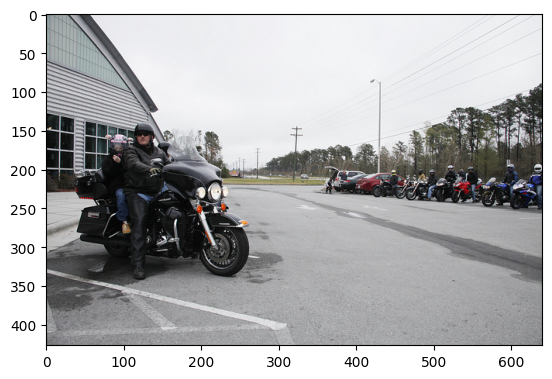

In [74]:
generate_caption('000000525021.jpg')

---------------------Actual---------------------
startseq train carrying chemical tanks traveling past water tower endseq
startseq dual train tracks with train on one of them and water tower in the background endseq
startseq train some trees and water tower endseq
startseq train on tracks with water tower for davis junction in the rear endseq
startseq train on train track going through bunch of trees endseq
--------------------Predicted--------------------
startseq train is parked in the middle of the tracks endseq


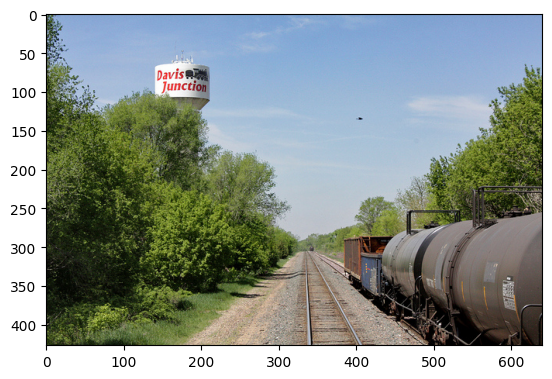

In [75]:
generate_caption('000000524611.jpg')

In [91]:
train_final[10:15]

['000000001237',
 '000000001350',
 '000000001577',
 '000000001700',
 '000000001757']

---------------------Actual---------------------
startseq watery glass jar full of blooming flowers endseq
startseq vase filled with yellow and white flowers endseq
startseq glass jar is filling with white and yellow flowers endseq
startseq glass vase is holding bunch of flowers endseq
startseq tall glass mug shaped vase with yellow flowers endseq
--------------------Predicted--------------------
startseq glass jar with flowers in it and glass endseq


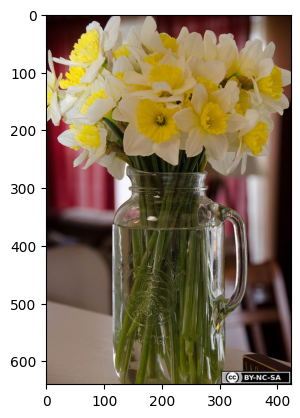

In [94]:
generate_caption('000000001577.jpg')